In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import time
import json
from collections import defaultdict
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import SVD, CoClustering
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from sqlalchemy import create_engine

# System I

For System 1 we recommend movies based only on their genre. The two recommender methods within this system will be finding the movies for that genre that have the highest weighted rating and the highest "trendy" weighted rating. The equation for weighted rating is given by:

$$r_w = \frac{m_\mu * n}{n + 90pct} + \frac{\mu * 90pct}{n + 90pct}$$

Where $m_\mu$ is the average rating for the movie, $n$ is the number of ratings for the movie, $\mu$ is the average rating among all movies, and $90pct$ is the 90th percentile of the number of ratings. 

A movie's "trendy" rating is simply its weighted rating times a time coefficient, except we use 50 percentile instead of 90. The time coeficient is a number between 0 and 1 where all movies released in the latest year in the database have a coeffcicient of 1 and all movies released in the earliest year in the database have a coefficient of 0. the function for updating the database with the weighted and trendy reviews is as follows:

In [ ]:
def movie_weights():
    e = create_engine("sqlite:///moviereviews.db")
    movies = pd.DataFrame(e.execute("SELECT MovieID, Title, Genre FROM movies").fetchall()).rename(columns={0: 'MovieID', 1: 'Title', 2:'Genres'})
    ratings = pd.DataFrame(e.execute("SELECT * FROM ratings").fetchall()).rename(columns={0: 'UserID', 1: 'MovieID', 2:'Rating', 3:'Timestamp'})
    movies['Year'] = movies['Title'].apply(lambda x: x[x.rfind("(")+1:-1]).apply(int) 
    firsttime = min(ratings['Timestamp'])
    lasttime = max(ratings['Timestamp'])
    
    def time_to_coef(timestamp):
        return (timestamp-firsttime)/(lasttime-firsttime)
    
    ratings['time_coef'] = ratings['Timestamp'].apply(time_to_coef)
    firstyear = min(movies['Year'])
    lastyear = max(movies['Year'])
    
    def year_to_coef(currentyear):
        return (currentyear-firstyear)/(lastyear-firstyear)
    
    movies['year_coef'] = movies['Year'].apply(year_to_coef)
    movies_genres = pd.concat([pd.Series(row['MovieID'], row['Genres'].split('|')) for _, row in movies.iterrows()]).reset_index().rename(columns={'index': 'Genre', 0: 'MovieID'})
    avg_time_coef = ratings.groupby(by=['MovieID'])['time_coef'].agg([np.mean]).rename(columns={'mean': 'avg_time_coef'})
    movie_grouped = ratings.groupby(by=['MovieID'])['Rating'].agg([np.sum, np.mean, np.std,np.ma.count]).merge(movies, on='MovieID')
    ninty_pct = np.percentile(movie_grouped['count'],90)
    fifty_pct = np.percentile(movie_grouped['count'],50)
    meanreview = np.mean(ratings['Rating'])
    
    #calculating weighted review
    movie_grouped['weighted_review'] = (movie_grouped['mean']*movie_grouped['count']/(movie_grouped['count']+ninty_pct)) + (meanreview*ninty_pct/(movie_grouped['count']+ninty_pct))
    
    #calculating trendy reviews
    movie_grouped['trendy_review'] = movie_grouped['year_coef']*((movie_grouped['mean']*movie_grouped['count']/(movie_grouped['count']+fifty_pct)) + (meanreview*fifty_pct/(movie_grouped['count']+fifty_pct)))
    movie_grouped = movie_grouped.rename(columns={'weighted_review': 'WeightedRating', 'trendy_review': 'TrendRating', 'Genres':'Genre'})
    movie_grouped[['MovieID','Title','Genre','WeightedRating','TrendRating']].to_sql('movies', if_exists='replace', con=e,index=False)

Once the database has been updated with weights it can be easily queried to find the top movies for a given genre. The query below can be used to find the best movies in the 'Sci-Fi' genre using both weighted and trendy recommender systems:

In [9]:
query = """
SELECT MovieID
  ,Title
  ,Type
  FROM (
  Select
  movies.MovieID
  ,Title
  ,'Weighted' Type
  ,movies.WeightedRating
  FROM movies
  INNER JOIN movie_genres
  ON movies.MovieID = movie_genres.MovieID
  WHERE movie_genres.Genre = 'Sci-Fi'
  ORDER BY movies.WeightedRating desc
  LIMIT 10) a

  UNION ALL

  SELECT MovieID
  ,Title
  ,Type
  FROM (
  Select
  movies.MovieID
  ,Title
  ,'Trendy' Type
  ,movies.TrendRating
  FROM movies
  INNER JOIN movie_genres
  ON movies.MovieID = movie_genres.MovieID
  WHERE movie_genres.Genre = 'Sci-Fi'
  ORDER BY movies.TrendRating desc
  LIMIT 10) b
"""

In [10]:
e = create_engine("sqlite:///api/moviereviews.db")
movies = pd.DataFrame(e.execute(query).fetchall()).rename(columns={0: 'MovieID', 1: 'Title', 2:'Type'})
movies.head(20)

,MovieID,Title,Type
0,260,Star Wars: Episode IV - A New Hope (1977),Weighted
1,2571,"Matrix, The (1999)",Weighted
2,1196,Star Wars: Episode V - The Empire Strikes Back...,Weighted
3,750,Dr. Strangelove or: How I Learned to Stop Worr...,Weighted
4,541,Blade Runner (1982),Weighted
5,1214,Alien (1979),Weighted
6,1240,"Terminator, The (1984)",Weighted
7,1200,Aliens (1986),Weighted
8,589,Terminator 2: Judgment Day (1991),Weighted
9,1210,Star Wars: Episode VI - Return of the Jedi (1983),Weighted


-------------------------------------------------------------------------------------------------------------

# System II

For system II we recommend movies based on the movies a user has seen, how the user rates those movies, and ratings for every other user. All available ratings can be used to group together similar movies as well as similar users to identify what movies a given user might like to see next. For our collaborative recommendation system we used python's "surprise" package which contains multiple algorthms which can be used to provide recommendations. The two algorithms I chose are "SVD" and "CoClustering". 

SVD stands for "singluar value decomposition" which is a linear algebra method of decomposing a rectangular matrix into three matrixies. If we run SVD on a matrix of movie ratings by user, the resulting three matrixes can be thought of as the affinity of each user to a given feature (genre, director etc...), the sigificance of each feature, and the amount of each feature contained in each movie. Since the matrix of user/movie ratings is very sparse, we cannot directly use SVD. Instead, we must estimate it with stocastic gradient decent. The estimated rating that a user will give an item is given by:

$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^T p_u$$

The unkowns of which can be estimated by minimizing the following expression:

$$\sum_{r_{ui}\epsilon R_{itrain}}{\left(r_{ui}-\hat{r}_{ui}\right)^2 + \lambda \left(b_i^2 + b_u^2 + \|q_i\|^2 + \|p_u\|^2\right)}$$

CoClustering is a colaborative filtering algorithm similar to k-means clustering. All users and items are assigned to clusters $C_u$ and $C_i$, and some co-clusters $C_{ui}$. The prediction $\hat{r}_{ui}$ is:

$$\hat{r}_{ui}=\overline{C_{ui}}+\left(\mu_u-\overline{C_u}\right) + \left(\mu_i - \overline{C_i}\right)$$

where $\overline{C_{ui}}$ is the average rating of co-cluster $C_{ui}$, $\overline{C_u}$ is the average rating of u's cluster, and $\overline{C_i}$ is the average rating of i's cluster. Clusters are assigned much like kmeans. 

## RSME Accuracy Metrics

The following demonstrates RSME accuracy on 10 test/train splits for each algorithm.

In [3]:
e = create_engine("sqlite:///api/moviereviews.db")

ratings = pd.DataFrame(e.execute("SELECT UserID,MovieID,Rating FROM ratings").fetchall()).rename(columns={0: 'UserID', 1: 'MovieID', 2:'Rating'})
reader = Reader()
data = Dataset.load_from_df(ratings, reader)


In [12]:


# Run 10-fold cross-validation and print results.

#cross_validate(algo, data, measures=['RMSE'], cv=10,  verbose=True);


accuracy_results=[]

for i in range(20):
    if i < 10:
        algo = SVD(reg_all=0.05, lr_all=0.007, n_epochs=30)
        algo_name = 'SVD'
    else:
        algo = CoClustering()
        algo_name = 'CoClustering'

    trainset, testset = train_test_split(data, test_size=.25)

    # Train the algorithm on the trainset, and predict ratings for the testset
    algofit=algo.fit(trainset)
    predictions = algo.test(testset)

    # Then compute RMSE
    accuracy_results.append({'algo': algo_name, 'i': i, 'RSME':accuracy.rmse(predictions)})




RMSE: 0.8555
RMSE: 0.8589
RMSE: 0.8572
RMSE: 0.8573
RMSE: 0.8580
RMSE: 0.8577
RMSE: 0.8584
RMSE: 0.8579
RMSE: 0.8575
RMSE: 0.8569
RMSE: 0.9149
RMSE: 0.9173
RMSE: 0.9191
RMSE: 0.9176
RMSE: 0.9159
RMSE: 0.9173
RMSE: 0.9130
RMSE: 0.9170
RMSE: 0.9233
RMSE: 0.9146


In [13]:
#print(accuracy_results)
df = pd.DataFrame(accuracy_results)
df.head(20)

,algo,i,RSME
0,SVD,0,0.855482
1,SVD,1,0.858931
2,SVD,2,0.857222
3,SVD,3,0.857282
4,SVD,4,0.857963
5,SVD,5,0.857690
6,SVD,6,0.858444
7,SVD,7,0.857943
8,SVD,8,0.857544
9,SVD,9,0.856899


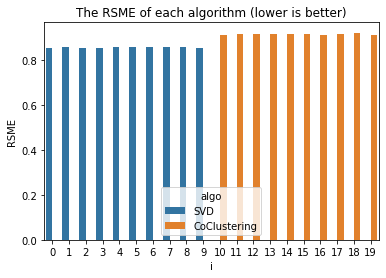

In [18]:
ax = sns.barplot(x="i", y="RSME", hue="algo", data=df).set_title('The RSME of each algorithm (lower is better)')

## Parameter Tuning

The SVD Algorithm's parameters were tuned using the grid search method. 

In [ ]:
param_grid = {'n_epochs': [10,20,30], 'lr_all': [0.005,0.006,0.007],'reg_all': [0.04,0.05,0.06]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

## Getting Recommendations

The following functions get the algorithm and get recommendations for the user who is using the web app.

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
def cf_recommend(ratings, algo, user_id):
    """Return the top-N recommendation for user user_id from a set of predictions.

    Args:
        ratings: The ratings that each user has given each movie
        algo: the surprise algorithm used for recommendations
        user_id: the user that we wish to provide recommendations for

    Returns:
    A list of movie ID's  that we recomend for user user_id.
    """
    # First train an algorithm on the movielens dataset.

    reader = Reader()
    data = Dataset.load_from_df(ratings, reader)
    trainset = data.build_full_trainset()
    
    algo.fit(trainset)
    
    user_ratings=ratings[ratings['UserID']==user_id]
    user_ratings=user_ratings[['UserID', 'MovieID', 'Rating']]

    
    ratings_dict = {'UserID': [9999] * len(trainset.all_items()),
                    'MovieID': list(trainset.all_items()),
                    'Rating': [4.5] * len(trainset.all_items())}
    
    user_ratings=pd.concat([user_ratings, pd.DataFrame(ratings_dict)])
    
    user_ratings = Dataset.load_from_df(user_ratings, reader).build_full_trainset()
    
    
    # Than predict ratings for all pairs (u, i) that are NOT in the training set.
    testset = user_ratings.build_anti_testset()
    predictions = algo.test(testset)
    
    top_n = get_top_n(predictions, n=10)
    
    
    # Return the recommended items for each user
    #for uid, user_ratings in top_n.items():
       # print(uid, [iid for (iid, _) in user_ratings])
    
    return pd.DataFrame(top_n[user_id]).rename(columns={0: 'MovieID', 1: 'Rating'})['MovieID'].tolist()

In [ ]:
try:
    
    #user ratings are loaded in as a JSON argument
    user_ratings=json.loads(sys.argv[1])
    
    e = create_engine("sqlite:///moviereviews.db")
    movies = pd.DataFrame(e.execute("SELECT MovieID, Title, Genre FROM movies").fetchall()).rename(columns={0: 'MovieID', 1: 'Title', 2:'Genres'})
    ratings = pd.DataFrame(e.execute("SELECT UserID,MovieID,Rating FROM ratings").fetchall()).rename(columns={0: 'UserID', 1: 'MovieID', 2:'Rating'})
    
    
    
    #We load ratings for a fake user 9998 and concatenate them to the rest of the rating datasest.
    user_ratings = {'UserID': [9998] * len(user_ratings.keys()),
                    'MovieID': list(user_ratings.keys()),
                    'Rating': list(user_ratings.values())}
    user_ratings = pd.DataFrame(user_ratings)
    
    ratings=pd.concat([user_ratings, ratings])
    
    #fit the training set and print recommendations in JSON format
    t = time.time()
    return_json={}
    return_json['SVD'] = cf_recommend(ratings, SVD(reg_all=0.05, lr_all=0.007, n_epochs=30), 9998)
    return_json['COCLUSTERING'] = cf_recommend(ratings, CoClustering(), 9998)
    elapsed = time.time() - t
    
    for idx, movieID in enumerate(return_json['SVD']):
        return_json['SVD'][idx]={'MovieID':movieID, 'Title': movies[movies['MovieID']==movieID]['Title'].to_list()[0]}
        
    for idx, movieID in enumerate(return_json['COCLUSTERING']):
        return_json['COCLUSTERING'][idx]={'MovieID':movieID, 'Title': movies[movies['MovieID']==movieID]['Title'].to_list()[0]}
        
    
    print(json.dumps(return_json))
    
except:
    print("A python exception occurred")